In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from hazm import *
from PersianStemmer import *
%matplotlib inline

In [157]:
def normalizetext(textstring):
    normalize = Normalizer()
    lemmatizer = Lemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in normalize.normalize(textstring).split() if word not in (stopwords_list())])

In [158]:
df = pd.read_csv('workorder.csv',delimiter=',',encoding='utf-8')
df.head()

,v1,v2
0,NOTCONS,اختصاص پروفايل
1,NOTCONS,نصب OverHual
2,CONS,نياز به يك عدد ماوس
3,NOTCONS,نصب ويندوز
4,CONS,نياز به تامين ست باطري كارت ساعت (9 تايي)


In [ ]:
df['v2'] = df['v2'].apply(normalizetext)
df.head()

In [133]:
# df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)

Text(0.5, 1.0, 'Number of ham and spam messages')

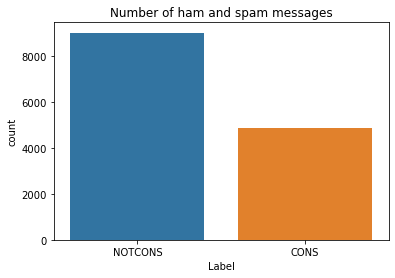

In [134]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [135]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [136]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20)

In [137]:
max_words = 2000
max_len = 300
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
print(tok)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [138]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,100,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(512,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [139]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 300)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 300, 100)          200000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               117248    
_________________________________________________________________
FC1 (Dense)                  (None, 512)               66048     
_________________________________________________________________
activation_11 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 513 

In [140]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

d:\shared\python37_64\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8856 samples, validate on 2215 samples
Epoch 1/10
8856/8856 [==============================] - 16s 2ms/step - loss: 0.2786 - accuracy: 0.8819 - val_loss: 0.2190 - val_accuracy: 0.9287
Epoch 2/10
8856/8856 [==============================] - 15s 2ms/step - loss: 0.3084 - accuracy: 0.9059 - val_loss: 0.1418 - val_accuracy: 0.9526
Epoch 3/10
8856/8856 [==============================] - 15s 2ms/step - loss: 0.1170 - accuracy: 0.9623 - val_loss: 0.1414 - val_accuracy: 0.9576
Epoch 4/10
8856/8856 [==============================] - 15s 2ms/step - loss: 0.1215 - accuracy: 0.9581 - val_loss: 0.1384 - val_accuracy: 0.9535
Epoch 5/10
8856/8856 [==============================] - 15s 2ms/step - loss: 0.1072 - accuracy: 0.9656 - val_loss: 0.1387 - val_accuracy: 0.9562


In [141]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [142]:
accr = model.evaluate(test_sequences_matrix,Y_test)


2768/2768 [==============================] - 3s 1ms/step


In [147]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]*100))

Test set
  Loss: 0.135
  Accuracy: 95.665


In [144]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(test_sequences_matrix).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)

In [145]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

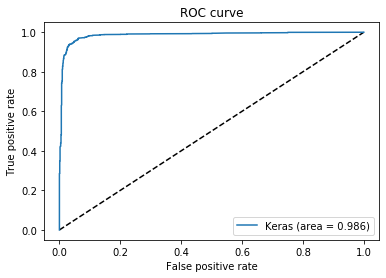

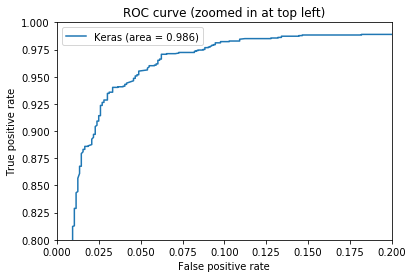

In [146]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()